# Package

In [224]:
import math
import matplotlib
import numpy as np
import pandas as pd
import pickle
import datetime
from plotly.offline import iplot
import yfinance as yf

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm_notebook

%matplotlib inline

# Init values

In [225]:
#### Input params ##################

load_data = False

period = "1mo"
interval = "1d"

train_size = 0.7          # split data into train, validation, and test with ratio of 0.7, 0.15, 0.15
val_size = 0.5

pred_date = '2021-06-30'        # Predict for this day, for the next H-1 days. Note indexing of days start from 0.

H = 21                         # Forecast horizon, in days. Note there are about 252 trading days in a year
N = 10                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

fontsize = 14
ticklabelsize = 14

####################################

# Load data

In [226]:
with open('data/jap_ticker.pickle', 'rb') as handle:
    tickers = pickle.load(handle)

In [227]:
if load_data:
    dfs = []
    for ticker in tqdm_notebook(tickers):
        try:
            temp_df = yf.download(ticker, period=period, interval=interval, progress=False)
            # create ticker column and sector column
            temp_df['ticker'] = ticker
            stock_info = yf.Ticker(ticker)
            temp_df['sector'] = stock_info.info["sector"]

            dfs.append(temp_df)
        except: pass

else:
    with open('data/jp_company_data_2022_7_6.pickle', 'rb') as handle:
        dfs = pickle.load(handle)

dfs[0].head()

,Open,High,Low,Close,Adj Close,Volume,ticker,sector
Date,,,,,,,,
2016-07-07,1010.000000,1023.799988,1004.400024,1014.599976,786.816711,53906000,7203.T,自動車・自動車部品
2016-07-08,1019.000000,1031.400024,1011.000000,1011.000000,784.024902,52315500,7203.T,自動車・自動車部品
2016-07-11,1011.000000,1011.000000,1011.000000,1011.000000,784.024902,0,7203.T,自動車・自動車部品
2016-07-12,1082.800049,1105.000000,1082.000000,1088.599976,844.203369,71689000,7203.T,自動車・自動車部品
2016-07-13,1113.199951,1128.599976,1103.000000,1125.599976,872.896423,97297000,7203.T,自動車・自動車部品


In [228]:
#with open('data/five_days.pickle', 'wb') as handle:
#    pickle.dump(dfs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [229]:
remove_df_i = []

for i, temp_df in enumerate(dfs):
    if temp_df.shape[0] == 0:
        print(temp_df.ticker)
        remove_df_i.append(i)
        continue
    temp_df.reset_index(inplace=True)
    # Change all column headings to be lower case, and remove spacing
    temp_df.columns = [str(x).lower().replace(' ', '_') for x in temp_df.columns]

    # Sort by datetime
    temp_df.sort_values(by='date', inplace=True, ascending=True)

    # Create returns column
    temp_df['daily_ret'] = 100.0 * ((temp_df['adj_close'].shift(-2) / temp_df['adj_close'])-1)

    # create weekday column
    temp_df['weekday'] = pd.to_datetime(temp_df['date']).dt.weekday

for index in sorted(remove_df_i, reverse=True):
    del dfs[index]

dfs[0].head()

,date,open,high,low,close,adj_close,volume,ticker,sector,daily_ret,weekday
0,2016-07-07,1010.000000,1023.799988,1004.400024,1014.599976,786.816711,53906000,7203.T,自動車・自動車部品,-0.354823,3
1,2016-07-08,1019.000000,1031.400024,1011.000000,1011.000000,784.024902,52315500,7203.T,自動車・自動車部品,7.675581,4
2,2016-07-11,1011.000000,1011.000000,1011.000000,1011.000000,784.024902,0,7203.T,自動車・自動車部品,11.335293,0
3,2016-07-12,1082.800049,1105.000000,1082.000000,1088.599976,844.203369,71689000,7203.T,自動車・自動車部品,3.766299,1
4,2016-07-13,1113.199951,1128.599976,1103.000000,1125.599976,872.896423,97297000,7203.T,自動車・自動車部品,2.327673,2


# Feature engineering

In [230]:
# Simple moving average
for temp_df in dfs:
    temp_df['sma_10'] = temp_df['adj_close'].rolling(window = 10).mean()
    temp_df['sma_20'] = temp_df['adj_close'].rolling(window = 20).mean()
    temp_df['sma_50'] = temp_df['adj_close'].rolling(window = 50).mean()
    temp_df['sma_100'] = temp_df['adj_close'].rolling(window = 100).mean()
    temp_df['sma_200'] = temp_df['adj_close'].rolling(window = 200).mean()

    # Get the sma on the previous day
    temp_df['adj_close_lag_1'] = temp_df['adj_close'].shift(1)
    temp_df['sma_10_lag_1'] = temp_df['sma_10'].shift(1)
    temp_df['sma_20_lag_1'] = temp_df['sma_20'].shift(1)
    temp_df['sma_50_lag_1'] = temp_df['sma_50'].shift(1)
    temp_df['sma_100_lag_1'] = temp_df['sma_100'].shift(1)
    temp_df['sma_200_lag_1'] = temp_df['sma_200'].shift(1)

    # Get above signals
    temp_df['sma_above20'] = (temp_df['adj_close'] > temp_df['sma_20']).astype(int)
    temp_df['sma_above50'] = (temp_df['adj_close'] > temp_df['sma_50']).astype(int)
    temp_df['sma_above100'] = (temp_df['adj_close'] > temp_df['sma_100']).astype(int)
    temp_df['sma_above200'] = (temp_df['adj_close'] > temp_df['sma_200']).astype(int)

    temp_df['sma_10above20'] = (temp_df['sma_10'] > temp_df['sma_20']).astype(int)
    temp_df['sma_10above50'] = (temp_df['sma_10'] > temp_df['sma_50']).astype(int)
    temp_df['sma_10above100'] = (temp_df['sma_10'] > temp_df['sma_100']).astype(int)
    temp_df['sma_10above200'] = (temp_df['sma_10'] > temp_df['sma_200']).astype(int)

    # Get bullish crossover signals
    temp_df['sma_cut20'] = ((temp_df['adj_close_lag_1'] < temp_df['sma_20_lag_1']) & (temp_df['sma_above20']==True)).astype(int)
    temp_df['sma_cut50'] = ((temp_df['adj_close_lag_1'] < temp_df['sma_50_lag_1']) & (temp_df['sma_above50']==True)).astype(int)
    temp_df['sma_cut100'] = ((temp_df['adj_close_lag_1'] < temp_df['sma_100_lag_1']) & (temp_df['sma_above100']==True)).astype(int)
    temp_df['sma_cut200'] = ((temp_df['adj_close_lag_1'] < temp_df['sma_200_lag_1']) & (temp_df['sma_above200']==True)).astype(int)

    temp_df['sma_10cut20'] = ((temp_df['sma_10_lag_1'] < temp_df['sma_20_lag_1']) & (temp_df['sma_10above20']==True)).astype(int)
    temp_df['sma_10cut50'] = ((temp_df['sma_10_lag_1'] < temp_df['sma_50_lag_1']) & (temp_df['sma_10above50']==True)).astype(int)
    temp_df['sma_10cut100'] = ((temp_df['sma_10_lag_1'] < temp_df['sma_100_lag_1']) & (temp_df['sma_10above100']==True)).astype(int)
    temp_df['sma_10cut200'] = ((temp_df['sma_10_lag_1'] < temp_df['sma_200_lag_1']) & (temp_df['sma_10above200']==True)).astype(int)

    # Get bearish crossover signals
    temp_df['sma_cut20down'] = ((temp_df['adj_close_lag_1'] > temp_df['sma_20_lag_1']) & (temp_df['adj_close'] < temp_df['sma_20'])).astype(int)
    temp_df['sma_cut50down'] = ((temp_df['adj_close_lag_1'] > temp_df['sma_50_lag_1']) & (temp_df['adj_close'] < temp_df['sma_50'])).astype(int)
    temp_df['sma_cut100down'] = ((temp_df['adj_close_lag_1'] > temp_df['sma_100_lag_1']) & (temp_df['adj_close'] < temp_df['sma_100'])).astype(int)
    temp_df['sma_cut200down'] = ((temp_df['adj_close_lag_1'] > temp_df['sma_200_lag_1']) & (temp_df['adj_close'] < temp_df['sma_200'])).astype(int)

    temp_df['sma_10cut20down'] = ((temp_df['sma_10_lag_1'] > temp_df['sma_20_lag_1']) & (temp_df['sma_10'] < temp_df['sma_20'])).astype(int)
    temp_df['sma_10cut50down'] = ((temp_df['sma_10_lag_1'] > temp_df['sma_50_lag_1']) & (temp_df['sma_10'] < temp_df['sma_50'])).astype(int)
    temp_df['sma_10cut100down'] = ((temp_df['sma_10_lag_1'] > temp_df['sma_100_lag_1']) & (temp_df['sma_10'] < temp_df['sma_100'])).astype(int)
    temp_df['sma_10cut200down'] = ((temp_df['sma_10_lag_1'] > temp_df['sma_200_lag_1']) & (temp_df['sma_10'] < temp_df['sma_200'])).astype(int)

In [231]:
# Del unneccesary cols
for df in dfs:
    df.drop(['sma_10', 'sma_50', 'sma_100', 'sma_200',
             'sma_10_lag_1', 'sma_20_lag_1', 'sma_50_lag_1', 'sma_100_lag_1', 'sma_200_lag_1'], axis=1, inplace=True)

## Exponential Moving Average



In [232]:
for df in dfs:
    # Exponential moving average
    df['ema_10'] = df['adj_close'].ewm(span = 10, adjust=False).mean()
    df['ema_20'] = df['adj_close'].ewm(span = 20, adjust=False).mean()
    df['ema_50'] = df['adj_close'].ewm(span = 50, adjust=False).mean()
    df['ema_100'] = df['adj_close'].ewm(span = 100, adjust=False).mean()
    df['ema_200'] = df['adj_close'].ewm(span = 200, adjust=False).mean()

    # Get the ema on the previous day
    df['adj_close_lag_1'] = df['adj_close'].shift(1)
    df['ema_10_lag_1'] = df['ema_10'].shift(1)
    df['ema_20_lag_1'] = df['ema_20'].shift(1)
    df['ema_50_lag_1'] = df['ema_50'].shift(1)
    df['ema_100_lag_1'] = df['ema_100'].shift(1)
    df['ema_200_lag_1'] = df['ema_200'].shift(1)

    # Get above signals
    df['ema_above20'] = (df['adj_close'] > df['ema_20']).astype(int)
    df['ema_above50'] = (df['adj_close'] > df['ema_50']).astype(int)
    df['ema_above100'] = (df['adj_close'] > df['ema_100']).astype(int)
    df['ema_above200'] = (df['adj_close'] > df['ema_200']).astype(int)

    df['ema_10above20'] = (df['ema_10'] > df['ema_20']).astype(int)
    df['ema_10above50'] = (df['ema_10'] > df['ema_50']).astype(int)
    df['ema_10above100'] = (df['ema_10'] > df['ema_100']).astype(int)
    df['ema_10above200'] = (df['ema_10'] > df['ema_200']).astype(int)

    # Get bullish crossover signals
    df['ema_cut20'] = ((df['adj_close_lag_1'] < df['ema_20_lag_1']) & (df['ema_above20']==True)).astype(int)
    df['ema_cut50'] = ((df['adj_close_lag_1'] < df['ema_50_lag_1']) & (df['ema_above50']==True)).astype(int)
    df['ema_cut100'] = ((df['adj_close_lag_1'] < df['ema_100_lag_1']) & (df['ema_above100']==True)).astype(int)
    df['ema_cut200'] = ((df['adj_close_lag_1'] < df['ema_200_lag_1']) & (df['ema_above200']==True)).astype(int)

    df['ema_10cut20'] = ((df['ema_10_lag_1'] < df['ema_20_lag_1']) & (df['ema_10above20']==True)).astype(int)
    df['ema_10cut50'] = ((df['ema_10_lag_1'] < df['ema_50_lag_1']) & (df['ema_10above50']==True)).astype(int)
    df['ema_10cut100'] = ((df['ema_10_lag_1'] < df['ema_100_lag_1']) & (df['ema_10above100']==True)).astype(int)
    df['ema_10cut200'] = ((df['ema_10_lag_1'] < df['ema_200_lag_1']) & (df['ema_10above200']==True)).astype(int)

    # Get bearish crossover signals
    df['ema_cut20down'] = ((df['adj_close_lag_1'] > df['ema_20_lag_1']) & (df['adj_close'] < df['ema_20'])).astype(int)
    df['ema_cut50down'] = ((df['adj_close_lag_1'] > df['ema_50_lag_1']) & (df['adj_close'] < df['ema_50'])).astype(int)
    df['ema_cut100down'] = ((df['adj_close_lag_1'] > df['ema_100_lag_1']) & (df['adj_close'] < df['ema_100'])).astype(int)
    df['ema_cut200down'] = ((df['adj_close_lag_1'] > df['ema_200_lag_1']) & (df['adj_close'] < df['ema_200'])).astype(int)

    df['ema_10cut20down'] = ((df['ema_10_lag_1'] > df['ema_20_lag_1']) & (df['ema_10'] < df['ema_20'])).astype(int)
    df['ema_10cut50down'] = ((df['ema_10_lag_1'] > df['ema_50_lag_1']) & (df['ema_10'] < df['ema_50'])).astype(int)
    df['ema_10cut100down'] = ((df['ema_10_lag_1'] > df['ema_100_lag_1']) & (df['ema_10'] < df['ema_100'])).astype(int)
    df['ema_10cut200down'] = ((df['ema_10_lag_1'] > df['ema_200_lag_1']) & (df['ema_10'] < df['ema_200'])).astype(int)

dfs[0].head()

,date,open,high,low,close,adj_close,volume,ticker,sector,daily_ret,...,ema_10cut100,ema_10cut200,ema_cut20down,ema_cut50down,ema_cut100down,ema_cut200down,ema_10cut20down,ema_10cut50down,ema_10cut100down,ema_10cut200down
0,2016-07-07,1010.000000,1023.799988,1004.400024,1014.599976,786.816711,53906000,7203.T,自動車・自動車部品,-0.354823,...,0,0,0,0,0,0,0,0,0,0
1,2016-07-08,1019.000000,1031.400024,1011.000000,1011.000000,784.024902,52315500,7203.T,自動車・自動車部品,7.675581,...,0,0,0,0,0,0,0,0,0,0
2,2016-07-11,1011.000000,1011.000000,1011.000000,1011.000000,784.024902,0,7203.T,自動車・自動車部品,11.335293,...,0,0,0,0,0,0,0,0,0,0
3,2016-07-12,1082.800049,1105.000000,1082.000000,1088.599976,844.203369,71689000,7203.T,自動車・自動車部品,3.766299,...,1,1,0,0,0,0,0,0,0,0
4,2016-07-13,1113.199951,1128.599976,1103.000000,1125.599976,872.896423,97297000,7203.T,自動車・自動車部品,2.327673,...,0,0,0,0,0,0,0,0,0,0


In [233]:
# Del unneccesary cols
for df in dfs:
    df.drop(['ema_10', 'ema_20', 'ema_50', 'ema_100', 'ema_200',
             'ema_10_lag_1', 'ema_20_lag_1', 'ema_50_lag_1', 'ema_100_lag_1', 'ema_200_lag_1'], axis=1, inplace=True)

## Moving Average Convergence Divergence

Implemented according to the definition in Investopedia:
https://www.investopedia.com/terms/m/macd.asp

In [234]:
for df in dfs:
    # Exponential moving average
    df['ema_12'] = df['adj_close'].ewm(span=12, adjust=False).mean()
    df['ema_26'] = df['adj_close'].ewm(span=26, adjust=False).mean()

    # MACD
    df['macd'] = df['ema_12'] - df['ema_26']
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

    # Get the macd on the previous day
    df['macd_lag_1'] = df['macd'].shift(1)
    df['macd_signal_lag_1'] = df['macd_signal'].shift(1)

    # Get bullish crossover signals
    df['macd_crossover'] = ((df['macd_lag_1'] < df['macd_signal_lag_1']) & \
                            (df['macd'] > df['macd_signal'])).astype(int)

    # Get bearish crossover signals
    df['macd_crossoverdown'] = ((df['macd_lag_1'] > df['macd_signal_lag_1']) & \
                            (df['macd'] < df['macd_signal'])).astype(int)

dfs[0].head()

,date,open,high,low,close,adj_close,volume,ticker,sector,daily_ret,...,ema_10cut100down,ema_10cut200down,ema_12,ema_26,macd,macd_signal,macd_lag_1,macd_signal_lag_1,macd_crossover,macd_crossoverdown
0,2016-07-07,1010.000000,1023.799988,1004.400024,1014.599976,786.816711,53906000,7203.T,自動車・自動車部品,-0.354823,...,0,0,786.816711,786.816711,0.000000,0.000000,NaN,NaN,0,0
1,2016-07-08,1019.000000,1031.400024,1011.000000,1011.000000,784.024902,52315500,7203.T,自動車・自動車部品,7.675581,...,0,0,786.387202,786.609911,-0.222708,-0.044542,0.000000,0.000000,0,0
2,2016-07-11,1011.000000,1011.000000,1011.000000,1011.000000,784.024902,0,7203.T,自動車・自動車部品,11.335293,...,0,0,786.023772,786.418429,-0.394657,-0.114565,-0.222708,-0.044542,0,0
3,2016-07-12,1082.800049,1105.000000,1082.000000,1088.599976,844.203369,71689000,7203.T,自動車・自動車部品,3.766299,...,0,0,794.974479,790.698795,4.275684,0.763485,-0.394657,-0.114565,1,0
4,2016-07-13,1113.199951,1128.599976,1103.000000,1125.599976,872.896423,97297000,7203.T,自動車・自動車部品,2.327673,...,0,0,806.962470,796.787508,10.174962,2.645781,4.275684,0.763485,0,0


In [235]:
for df in dfs:
    # Del unneccesary cols
    df.drop(['ema_12', 'ema_26', 'macd_signal', 'macd_lag_1', 'macd_signal_lag_1'], axis=1, inplace=True)

## Stochastic Oscillator
Implemented according to the definition in Investopedia:
https://www.investopedia.com/terms/s/stochasticoscillator.asp#:~:text=A%20stochastic%20oscillator%20is%20a,moving%20average%20of%20the%20result.

In [236]:
for df in dfs:
    # Generate fast and slow stochastic oscillators
    df['lowest_14'] = df['adj_close'].rolling(window = 14).min()
    df['highest_14'] = df['adj_close'].rolling(window = 14).max()
    df['stochastic_fast'] = 100.0*(df['adj_close'] - df['lowest_14'])/(df['highest_14'] - df['lowest_14'])
    df['stochastic_slow'] = df['stochastic_fast'].rolling(window = 3).mean()

    # Get the stochastics on the previous day
    df['stochastic_fast_lag_1'] = df['stochastic_fast'].shift(1)
    df['stochastic_slow_lag_1'] = df['stochastic_slow'].shift(1)

    # Get bullish crossover signals
    df['stochastic_fastcutslow'] = ((df['stochastic_fast_lag_1'] < df['stochastic_slow_lag_1']) & \
                                    (df['stochastic_fast'] > df['stochastic_slow'])).astype(int)

    # Get bearish crossover signals
    df['stochastic_fastcutslowdown'] = ((df['stochastic_fast_lag_1'] > df['stochastic_slow_lag_1']) & \
                                    (df['stochastic_fast'] < df['stochastic_slow'])).astype(int)

    # Get overbought/oversold signals
    df['stochastic_overs'] = (df['stochastic_fast'] < 20).astype(int)
    df['stochastic_overb'] = (df['stochastic_fast'] > 80).astype(int)

dfs[0].head()

,date,open,high,low,close,adj_close,volume,ticker,sector,daily_ret,...,lowest_14,highest_14,stochastic_fast,stochastic_slow,stochastic_fast_lag_1,stochastic_slow_lag_1,stochastic_fastcutslow,stochastic_fastcutslowdown,stochastic_overs,stochastic_overb
0,2016-07-07,1010.000000,1023.799988,1004.400024,1014.599976,786.816711,53906000,7203.T,自動車・自動車部品,-0.354823,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1,2016-07-08,1019.000000,1031.400024,1011.000000,1011.000000,784.024902,52315500,7203.T,自動車・自動車部品,7.675581,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2,2016-07-11,1011.000000,1011.000000,1011.000000,1011.000000,784.024902,0,7203.T,自動車・自動車部品,11.335293,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
3,2016-07-12,1082.800049,1105.000000,1082.000000,1088.599976,844.203369,71689000,7203.T,自動車・自動車部品,3.766299,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
4,2016-07-13,1113.199951,1128.599976,1103.000000,1125.599976,872.896423,97297000,7203.T,自動車・自動車部品,2.327673,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0


In [237]:
# Del unneccesary cols
for df in dfs:
    df.drop(['lowest_14', 
             'highest_14', 
             'stochastic_fast_lag_1', 
             'stochastic_slow_lag_1'], axis=1, inplace=True)

## Relative Strength Index
Implemented according to:

https://www.investopedia.com/terms/r/rsi.asp

https://school.stockcharts.com/doku.php?id=technical_indicators:relative_strength_index_rsi

In [238]:
for df in dfs:
    # Get gain and loss columns
    df['gain'] = df['daily_ret']
    df.loc[df['gain']<0, 'gain'] = 0

    df['loss'] = df['daily_ret']
    df.loc[df['loss']>0, 'loss'] = 0
    df['loss'] = abs(df['loss'])

    # Get avg_gain, avg_loss columns
    df['avg_gain'] = df['gain'].rolling(window = 14).mean()
    df['avg_loss'] = df['loss'].rolling(window = 14).mean()

    for index, row in df[15:].iterrows():
        df.loc[index, 'avg_gain'] = (df.loc[index-1, 'avg_gain']*13 + row['gain'])/14
        df.loc[index, 'avg_loss'] = (df.loc[index-1, 'avg_loss']*13 + row['loss'])/14

    # Calc RSI
    df['rsi'] = 100 - 100/(1+(df['avg_gain']/df['avg_loss']))
    df['rsi_ob'] = (df['rsi'] > 70).astype(int)
    df['rsi_os'] = (df['rsi'] < 30).astype(int)

dfs[0].head()

,date,open,high,low,close,adj_close,volume,ticker,sector,daily_ret,...,stochastic_fastcutslowdown,stochastic_overs,stochastic_overb,gain,loss,avg_gain,avg_loss,rsi,rsi_ob,rsi_os
0,2016-07-07,1010.000000,1023.799988,1004.400024,1014.599976,786.816711,53906000,7203.T,自動車・自動車部品,-0.354823,...,0,0,0,0.000000,0.354823,NaN,NaN,NaN,0,0
1,2016-07-08,1019.000000,1031.400024,1011.000000,1011.000000,784.024902,52315500,7203.T,自動車・自動車部品,7.675581,...,0,0,0,7.675581,0.000000,NaN,NaN,NaN,0,0
2,2016-07-11,1011.000000,1011.000000,1011.000000,1011.000000,784.024902,0,7203.T,自動車・自動車部品,11.335293,...,0,0,0,11.335293,0.000000,NaN,NaN,NaN,0,0
3,2016-07-12,1082.800049,1105.000000,1082.000000,1088.599976,844.203369,71689000,7203.T,自動車・自動車部品,3.766299,...,0,0,0,3.766299,0.000000,NaN,NaN,NaN,0,0
4,2016-07-13,1113.199951,1128.599976,1103.000000,1125.599976,872.896423,97297000,7203.T,自動車・自動車部品,2.327673,...,0,0,0,2.327673,0.000000,NaN,NaN,NaN,0,0


In [239]:
# Del unneccesary cols
for df in dfs:
    df.drop(['gain', 
             'loss'
            ], axis=1, inplace=True)

## Average True Range
Implemented according to the definition in Investopedia: https://www.investopedia.com/terms/a/atr.asp

In [240]:
for df in dfs:
    # Get atr
    df['close_lag_1'] = df['close'].shift(1)
    df['tr'] = np.maximum(df['high']-df['low'], np.maximum(abs(df['high']-df['close_lag_1']), abs(df['low']-df['close_lag_1'])))
    df['atr'] = df['tr'].rolling(window = 14).mean()
    
    # Get bullish atr signal - buy when next day's price is above yesterday's closing + atr
    df['atr_signal'] = (df['high'] > ((df['close_lag_1'] + df['atr']))).astype(int)
    
    # Get bearish atr signal - sell when next day's price is below yesterday's closing - atr
    df['atr_signaldown'] = (df['low'] < ((df['close_lag_1'] - df['atr']))).astype(int)

In [241]:
# Del unneccesary cols
for df in dfs:
    df.drop(['close_lag_1'], axis=1, inplace=True)  

## Average Directional Index
Implemented according to:

https://www.investopedia.com/terms/a/adx.asp

https://school.stockcharts.com/doku.php?id=technical_indicators:average_directional_index_adx

In [242]:
for df in dfs:
    # Get +/- directional movement
    df['high_lag_1'] = df['high'].shift(1)
    df['low_lag_1'] = df['low'].shift(1)
    
    def comp_pdm(high, high_lag_1, low, low_lag_1):
        if (high-high_lag_1) > (low_lag_1-low):
            return(max(high-high_lag_1, 0))
        else:
            return 0
        
    df['+dm'] = df.apply(lambda row: comp_pdm(row['high'], row['high_lag_1'], row['low'], row['low_lag_1']), axis=1)
        
    def comp_mdm(high, high_lag_1, low, low_lag_1):
        if (low_lag_1-low) > (high-high_lag_1):
            return(max(low_lag_1-low, 0))
        else:
            return 0
    
    df['-dm'] = df.apply(lambda row: comp_mdm(row['high'], row['high_lag_1'], row['low'], row['low_lag_1']), axis=1)
        
        
    # Get smoothed +/- directional movement
    df['smoothed+dm'] = 0
    df.loc[14, 'smoothed+dm'] = df[1:15]['+dm'].sum()
    
    df['smoothed-dm'] = 0
    df.loc[14, 'smoothed-dm'] = df[1:15]['-dm'].sum()
    
    df['14tr'] = 0
    df.loc[14, '14tr'] = df[1:15]['tr'].sum()
    
    for index, row in df[15:].iterrows():
        df.loc[index, 'smoothed+dm'] = df.loc[index-1, 'smoothed+dm'] - (df.loc[index-1, 'smoothed+dm']/14) + row['+dm']
        df.loc[index, 'smoothed-dm'] = df.loc[index-1, 'smoothed-dm'] - (df.loc[index-1, 'smoothed-dm']/14) + row['-dm']
        df.loc[index, '14tr'] = df.loc[index-1, '14tr'] - (df.loc[index-1, '14tr']/14) + row['tr']
        
    # Get +/- directional index
    df['+di'] = 100.0*(df['smoothed+dm']/df['14tr'])
    df['-di'] = 100.0*(df['smoothed-dm']/df['14tr'])
    
    # Get directional movement index
    df['dx'] = 100.0 * (abs(df['+di']-df['-di'])/abs(df['+di']+df['-di']))
    
    # Get average directional movement index
    df.loc[27, 'adx'] = df[14:28]['dx'].mean()
    for index, row in df[28:].iterrows():
        df.loc[index, 'adx'] = (df.loc[index-1, 'adx']*13 + row['dx'])/14
        
    # Get adx strength and trendless
    df['adx_strength'] = (df['adx'] > 25).astype(int)
    df['adx_trendless'] = (df['adx'] < 20).astype(int)
    
    # Get adx signals
    df['+di_lag_1'] = df['+di'].shift(1)
    df['-di_lag_1'] = df['-di'].shift(1)
    df['adx_bull'] = ((df['+di_lag_1'] < df['-di_lag_1']) & (df['+di'] > df['-di']) & (df['adx_strength']==True)).astype(int)
    df['adx_bear'] = ((df['-di_lag_1'] < df['+di_lag_1']) & (df['-di'] > df['+di']) & (df['adx_strength']==True)).astype(int)


In [243]:
# Del unneccesary cols
for df in dfs:
    df.drop(['+di',
             '-di',
             '+di_lag_1',
             '-di_lag_1',
             'tr', 
             '+dm', 
             '-dm', 
             'smoothed+dm',
             'smoothed-dm',
             '14tr',
             'dx',
             'tr'], axis=1, inplace=True)

## Bollinger Bands

In [244]:
for df in dfs:
    df['std_20'] = df['adj_close'].rolling(window = 20).std()
    df['bollinger_upp'] = df['sma_20'] + 2*df['std_20']
    df['bollinger_low'] = df['sma_20'] - 2*df['std_20']
    
    # Get dist between bollinger bands and the price
    df['bollinger_upp_dist'] = df['bollinger_upp'] - df['adj_close']
    df['bollinger_low_dist'] = df['adj_close'] - df['bollinger_low']
    
    # Get signals
    df['bollinger_ob'] = (df['adj_close'] > df['bollinger_upp']).astype(int)
    df['bollinger_os'] = (df['adj_close'] < df['bollinger_low']).astype(int)


In [245]:
# Del unneccesary cols
for df in dfs:
    df.drop(['std_20', 'bollinger_upp', 'bollinger_low'], axis=1, inplace=True)

In [246]:
# Remove unnecessary cols
for df in dfs:
    df.drop(['open',
             'high', 
             'low',
             'close',
             'volume',
             'sma_20',
             'adj_close_lag_1',
             'high_lag_1',
             'low_lag_1',
             ], axis=1, inplace=True)

# EDA

In [275]:
def add_lags(df_list, columns, N):
    dfs = [df.copy(deep=True) for df in df_list]
    for df in dfs:
        for col in columns:
            for i in range(1, N):
                df[f'{col}_lag_{i}'] = df[col].shift(i)
    return dfs

In [276]:
# create lag for daily return to N days ahead
dfs_lags = add_lags(dfs, ['daily_ret'], N)
dfs_lags[0].shape


(1486, 89)

In [277]:
# Create lags for technical indicators
tech_indicators = list(set(dfs[0].columns) - set(['date', 'daily_ret', 'sector', 'ticker', 'weekday']))

dfs_lags = add_lags(dfs_lags, tech_indicators, 2)
dfs_lags[0].shape

(1486, 164)

In [278]:
# Remove columns
for df in dfs_lags:
    df.drop(tech_indicators, axis=1, inplace=True)
dfs_lags[0].shape

(1486, 89)

In [279]:
df_lags = pd.concat(dfs_lags)
df_lags.head()

,date,ticker,sector,daily_ret,weekday,daily_ret_lag_1,daily_ret_lag_2,daily_ret_lag_3,daily_ret_lag_4,daily_ret_lag_5,...,sma_above20_lag_1,sma_10cut200_lag_1,ema_10above20_lag_1,ema_above50_lag_1,ema_10cut50_lag_1,ema_above200_lag_1,bollinger_low_dist_lag_1,sma_10above50_lag_1,ema_cut50down_lag_1,sma_10cut100_lag_1
0,2016-07-07,7203.T,自動車・自動車部品,-0.354823,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-08,7203.T,自動車・自動車部品,7.675581,4,-0.354823,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
2,2016-07-11,7203.T,自動車・自動車部品,11.335293,0,7.675581,-0.354823,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
3,2016-07-12,7203.T,自動車・自動車部品,3.766299,1,11.335293,7.675581,-0.354823,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
4,2016-07-13,7203.T,自動車・自動車部品,2.327673,2,3.766299,11.335293,7.675581,-0.354823,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,NaN,0.0,0.0,0.0


In [280]:
#df_lags = df_lags[abs(df_lags['daily_ret']) <= 50]
df_lags.drop(columns=['daily_ret_lag_1'], inplace=True)

In [281]:
with open('encoders/jp_date_2022_7_6.pickle', 'rb') as handle:
    date_encoder = pickle.load(handle)

with open('encoders/jp_sector_2022_7_6.pickle', 'rb') as handle:
    sector_encoder = pickle.load(handle)

with open('encoders/jp_ticker_2022_7_6.pickle', 'rb') as handle:
    ticker_encoder = pickle.load(handle)

In [282]:
# label encode for categorical variables: sector and ticker column
df_lags['date'] = date_encoder.fit_transform(df_lags['date'])

df_lags['sector'] = sector_encoder.fit_transform(df_lags['sector'])

df_lags['ticker'] = ticker_encoder.fit_transform(df_lags['ticker'])
df_lags.tail()

,date,ticker,sector,daily_ret,weekday,daily_ret_lag_2,daily_ret_lag_3,daily_ret_lag_4,daily_ret_lag_5,daily_ret_lag_6,...,sma_above20_lag_1,sma_10cut200_lag_1,ema_10above20_lag_1,ema_above50_lag_1,ema_10cut50_lag_1,ema_above200_lag_1,bollinger_low_dist_lag_1,sma_10above50_lag_1,ema_cut50down_lag_1,sma_10cut100_lag_1
1481,1481,70,9,2.226261,4,-7.482135,-6.412338,-2.778913,3.096234,1.283113,...,0.0,0.0,0.0,0.0,0.0,0.0,30.937530,0.0,0.0,0.0
1482,1482,70,9,-2.199282,0,-3.382480,-7.482135,-6.412338,-2.778913,3.096234,...,0.0,0.0,0.0,0.0,0.0,0.0,-23.228179,0.0,0.0,0.0
1483,1483,70,9,-4.800000,1,2.226261,-3.382480,-7.482135,-6.412338,-2.778913,...,0.0,0.0,0.0,0.0,0.0,0.0,41.384934,0.0,0.0,0.0
1484,1484,70,9,NaN,2,-2.199282,2.226261,-3.382480,-7.482135,-6.412338,...,0.0,0.0,0.0,0.0,0.0,0.0,88.530629,0.0,0.0,0.0
1485,1485,70,9,NaN,3,-4.800000,-2.199282,2.226261,-3.382480,-7.482135,...,0.0,0.0,0.0,0.0,0.0,0.0,50.788454,0.0,0.0,0.0


# predicting


In [283]:
temp = df_lags.copy(deep=True)

In [284]:
df_lags = temp.copy(deep=True)

In [285]:
days_ago = 0

In [286]:
df_lags[df_lags['date'] == (df_lags['date'].max())].tail()

,date,ticker,sector,daily_ret,weekday,daily_ret_lag_2,daily_ret_lag_3,daily_ret_lag_4,daily_ret_lag_5,daily_ret_lag_6,...,sma_above20_lag_1,sma_10cut200_lag_1,ema_10above20_lag_1,ema_above50_lag_1,ema_10cut50_lag_1,ema_above200_lag_1,bollinger_low_dist_lag_1,sma_10above50_lag_1,ema_cut50down_lag_1,sma_10cut100_lag_1
1485,1485,231,27,NaN,3,-2.640845,-0.718133,2.158273,-3.633218,-4.302926,...,0.0,0.0,0.0,0.0,0.0,1.0,19.771269,1.0,1.0,0.0
1485,1485,85,9,NaN,3,2.102102,0.200602,-0.299401,-0.894632,-0.397614,...,1.0,0.0,1.0,1.0,0.0,0.0,247.409247,1.0,0.0,0.0
1485,1485,283,29,NaN,3,-1.021566,-1.366743,2.680653,0.688073,-1.265823,...,1.0,0.0,1.0,1.0,0.0,1.0,51.218616,1.0,0.0,0.0
1485,1485,284,29,NaN,3,-1.794311,-2.897278,2.742806,1.515152,-0.044944,...,1.0,0.0,1.0,1.0,0.0,1.0,263.428097,1.0,0.0,0.0
1485,1485,70,9,NaN,3,-4.800000,-2.199282,2.226261,-3.382480,-7.482135,...,0.0,0.0,0.0,0.0,0.0,0.0,50.788454,0.0,0.0,0.0


In [287]:
predicting = df_lags[df_lags['date'] == (df_lags['date'].max() - days_ago)]
actual = predicting['daily_ret']
predicting.drop(['daily_ret'], axis=1, inplace=True)

/var/folders/kx/kj70wzv55d30dqrqqm60c3t80000gn/T/ipykernel_31106/2640571131.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [288]:
with open('encoders/jp_starndard_2022_7_6.pickle', 'rb') as handle:
    sc = pickle.load(handle)
predicting_std = sc.transform(predicting)

/Users/ryuseitaniguchi/Downloads/stock/venv/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning:

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.




In [289]:
predicting_std.shape

(300, 87)

In [308]:
pd.set_option('display.max_columns',100)
predicting.tail()

,date,ticker,sector,weekday,daily_ret_lag_2,daily_ret_lag_3,daily_ret_lag_4,daily_ret_lag_5,daily_ret_lag_6,daily_ret_lag_7,daily_ret_lag_8,daily_ret_lag_9,ema_10cut200down_lag_1,sma_10cut100down_lag_1,stochastic_fastcutslowdown_lag_1,sma_cut20_lag_1,bollinger_os_lag_1,rsi_os_lag_1,macd_crossover_lag_1,bollinger_ob_lag_1,stochastic_slow_lag_1,ema_10cut20down_lag_1,sma_above200_lag_1,ema_10cut100down_lag_1,avg_loss_lag_1,rsi_ob_lag_1,ema_cut100_lag_1,atr_signaldown_lag_1,sma_cut200_lag_1,sma_10above20_lag_1,atr_lag_1,sma_10cut200down_lag_1,sma_10above100_lag_1,adx_trendless_lag_1,bollinger_upp_dist_lag_1,macd_lag_1,macd_crossoverdown_lag_1,rsi_lag_1,adx_lag_1,ema_cut200_lag_1,sma_cut50down_lag_1,ema_cut20down_lag_1,sma_above50_lag_1,ema_10cut100_lag_1,sma_10cut50down_lag_1,ema_10above200_lag_1,ema_cut50_lag_1,sma_10cut20_lag_1,sma_cut100down_lag_1,ema_cut200down_lag_1,atr_signal_lag_1,sma_above100_lag_1,ema_above100_lag_1,sma_10cut20down_lag_1,stochastic_fast_lag_1,adx_bull_lag_1,stochastic_overb_lag_1,sma_cut50_lag_1,avg_gain_lag_1,adx_strength_lag_1,sma_cut100_lag_1,adj_close_lag_1,ema_10cut200_lag_1,sma_cut20down_lag_1,ema_cut100down_lag_1,sma_cut200down_lag_1,stochastic_fastcutslow_lag_1,adx_bear_lag_1,ema_10cut20_lag_1,ema_10above100_lag_1,sma_10above200_lag_1,ema_10above50_lag_1,ema_above20_lag_1,sma_10cut50_lag_1,ema_cut20_lag_1,ema_10cut50down_lag_1,stochastic_overs_lag_1,sma_above20_lag_1,sma_10cut200_lag_1,ema_10above20_lag_1,ema_above50_lag_1,ema_10cut50_lag_1,ema_above200_lag_1,bollinger_low_dist_lag_1,sma_10above50_lag_1,ema_cut50down_lag_1,sma_10cut100_lag_1
1485,1485,231,27,3,-2.640845,-0.718133,2.158273,-3.633218,-4.302926,-0.172712,2.650177,1.223776,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,13.978495,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,176.428571,0.0,1.0,1.0,516.771269,-4.516956,0.0,NaN,17.379381,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.0,NaN,0.0,0.0,5530.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,19.771269,1.0,1.0,0.0
1485,1485,85,9,3,2.102102,0.200602,-0.299401,-0.894632,-0.397614,-1.372549,-0.592885,0.990099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.111111,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,1.0,123.571429,0.0,1.0,1.0,213.409247,35.545869,0.0,NaN,18.309003,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,72.000000,0.0,0.0,0.0,NaN,0.0,0.0,4995.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,247.409247,1.0,0.0,0.0
1485,1485,283,29,3,-1.021566,-1.366743,2.680653,0.688073,-1.265823,0.345224,1.164144,2.597403,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,90.566038,0.0,1.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,15.428571,0.0,1.0,1.0,19.118616,7.939524,0.0,NaN,14.788290,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,71.698113,0.0,0.0,0.0,NaN,0.0,0.0,866.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,51.218616,1.0,0.0,0.0
1485,1485,284,29,3,-1.794311,-2.897278,2.742806,1.515152,-0.044944,4.081633,8.009709,6.785537,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,90.987654,0.0,1.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,69.571429,0.0,1.0,0.0,102.728097,53.036377,0.0,NaN,27.485091,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,72.962963,0.0,0.0,0.0,NaN,1.0,0.0,2212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,263.428097,1.0,0.0,0.0
1485,1485,70,9,3,-4.800000,-2.199282,2.226261,-3.382480,-7.482135,-6.412338,-2.778913,3.096234,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.760818,0.0,0.0,0.0,NaN,0.0,0.0,1.0,0.0,0.0,95.357143,0.0,0.0,0.0,552.688454,-69.394627,0.0,NaN,22.319203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,0.0,0.0,2179.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,50.788454,0.0,0.0,0.0


## XGBOOST

In [291]:
with open('models/jp_xgboost_2022_7_6.pickle', 'rb') as handle:
    xgb = pickle.load(handle)

### Predict

In [292]:
prediction = xgb.predict(predicting_std)

In [293]:
from matplotlib import pyplot as plt


def show_prediction_scatter(y_pred, y_valid):
    fig, ax = plt.subplots()

    ax.set_xlabel("predicted daily returns")
    ax.set_ylabel("actural daily returns")
    ax.scatter(y_pred, y_valid)

    # y = x
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

    ax.plot(lims, [0,0], 'r-', alpha=0.75)
    ax.plot([0,0], lims, 'r-', alpha=0.75)

    ax.set_aspect('equal')

In [294]:
predicting.head()

,date,ticker,sector,weekday,daily_ret_lag_2,daily_ret_lag_3,daily_ret_lag_4,daily_ret_lag_5,daily_ret_lag_6,daily_ret_lag_7,...,sma_above20_lag_1,sma_10cut200_lag_1,ema_10above20_lag_1,ema_above50_lag_1,ema_10cut50_lag_1,ema_above200_lag_1,bollinger_low_dist_lag_1,sma_10above50_lag_1,ema_cut50down_lag_1,sma_10cut100_lag_1
1485,1485,186,21,3,-2.244271,-2.602934,2.394775,0.619048,-2.866541,-3.114187,...,0.0,0.0,0.0,0.0,0.0,0.0,26.517693,0.0,0.0,0.0
1484,1485,1,2,3,-3.428283,-0.734549,1.900848,-0.025323,-2.455525,-1.741727,...,0.0,0.0,0.0,0.0,0.0,0.0,55.786411,0.0,0.0,0.0
1485,1485,275,23,3,-1.565307,-2.223358,0.308880,0.436345,-0.943396,-1.789766,...,0.0,0.0,0.0,0.0,0.0,1.0,34.046090,1.0,1.0,0.0
1485,1485,161,30,3,-1.395768,-1.857725,2.728955,-0.540784,-5.877231,-4.353448,...,0.0,0.0,0.0,0.0,0.0,0.0,244.814251,0.0,0.0,0.0
1485,1485,167,30,3,3.695791,3.316821,2.631002,0.107805,-2.688287,-2.027883,...,1.0,0.0,0.0,0.0,0.0,0.0,3704.844978,0.0,0.0,0.0


In [295]:
predicted_max_ret = prediction.max()
predicted_max_i = prediction.argmax()
ticker = ticker_encoder.classes_[int(predicting.iloc[predicted_max_i]['ticker'])]

print(f'Date: {datetime.date.today()+ datetime.timedelta(days=1)}')
print(f'Ticker: {ticker}')
print(f'Predicted max daily return: {predicted_max_ret}')

Date: 2022-07-07
Ticker: 1605.T
Predicted max daily return: 15.902724266052246


In [296]:
data = {
    'prediction': list(prediction),
    'actual': [actual.iloc[i] for i in range(len(prediction))],
}

result = pd.DataFrame(data)
result.index = [ticker_encoder.classes_[int(predicting.iloc[i]['ticker'])] for i in result.index]

### Result

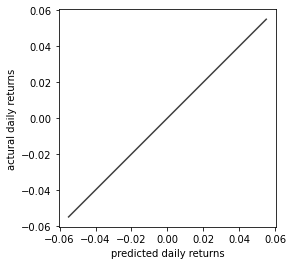

In [297]:
show_prediction_scatter(prediction, actual)

In [298]:
result.sort_values(by='prediction', ascending=False).head()

,prediction,actual
1605.T,15.902724,NaN
1963.T,11.942191,NaN
8354.T,10.145427,NaN
7013.T,9.778902,NaN
8002.T,9.122625,NaN


## Random Forest

In [302]:
with open('models/jp_rf_2022_7_6.pickle', 'rb') as handle:
    rf = pickle.load(handle)

### Predict

In [303]:
predicting.isnull().sum()

date                        0
ticker                      0
sector                      0
weekday                     0
daily_ret_lag_2             0
                           ..
ema_above200_lag_1          0
bollinger_low_dist_lag_1    0
sma_10above50_lag_1         0
ema_cut50down_lag_1         0
sma_10cut100_lag_1          0
Length: 87, dtype: int64

In [305]:
prediction = rf.predict(predicting_std)

ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
data = {
    'prediction': list(prediction),
    'actual': [actual.iloc[i] for i in range(len(prediction))],
}

result = pd.DataFrame(data)
result.index = [ticker_encoder.classes_[int(predicting.iloc[i]['ticker'])] for i in result.index]

### Result

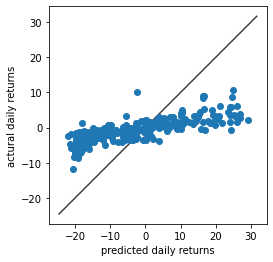

In [ ]:
show_prediction_scatter(prediction, actual)

In [ ]:
result.sort_values(by='prediction', ascending=False).head(10)

,prediction,actual
4684.T,29.129196,2.311854
8113.T,27.039475,3.778881
4704.T,26.901611,2.710414
6845.T,26.230402,2.533333
3774.T,26.131665,6.185567
4613.T,25.986462,1.463415
4307.T,25.726653,3.178808
4739.T,25.597750,3.211679
6920.T,25.229052,3.638606
3769.T,24.919009,10.780287
